In [0]:
from google.colab import drive
drive.mount('/gdrive')
! pip install -q corner

In [2]:
% tensorflow_version 2.x
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import os
import pickle
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


# Reading data

In [3]:
#getting data from drive
path = '/gdrive/My Drive/Machine_learning/GSOC_Evaluation_Datasets/'
os.listdir(path)

['all_jets_test_4D_100_percent.pkl', 'all_jets_train_4D_100_percent.pkl']

In [4]:
# reading the data from pickle files
df = pd.read_pickle(f'{path}all_jets_train_4D_100_percent.pkl')
print(df.shape)
df.head()

(111778, 4)


,m,pt,phi,eta
132784,3831.839355,22000.609375,1.567018,1.142924
99666,4582.417480,21648.210938,-2.680558,0.213654
26629,16747.765625,169514.281250,-1.948239,1.163296
80473,14789.586914,183085.609375,-1.641102,2.670927
48229,4646.724121,20527.130859,2.922270,-1.158871


In [5]:
df_test = pd.read_pickle(f'{path}all_jets_test_4D_100_percent.pkl')
print(df_test.shape)
df_test.head()

(27945, 4)


,m,pt,phi,eta
85972,4983.729980,23798.070312,1.962157,-0.059532
38742,5435.273438,21881.867188,1.035412,0.734343
128711,5239.408691,24608.134766,-1.121055,0.828848
28751,14121.240234,203110.953125,0.324205,-2.571108
131358,3344.826660,24897.294922,0.395331,1.440069


# EDA and Data Preprocessing

In [6]:
# understanding the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
m,111778.0,8941.356799,7421.270111,-0.045353,4658.248535,5728.732910,10467.514160,128247.671875
pt,111778.0,64458.683471,69874.993026,20000.154297,22514.718750,27141.585938,78976.080078,748795.937500
phi,111778.0,0.001691,1.803151,-3.141587,-1.558285,0.019362,1.553306,3.141546
eta,111778.0,0.043500,1.448439,-4.745398,-1.139831,0.086258,1.178913,4.747644


In [7]:
# checking for null values
print(f'NaNs in train: {df.isnull().sum().sum()}')
print(f'NaNs in test: {df_test.isnull().sum().sum()}')

NaNs in train: 0
NaNs in test: 0


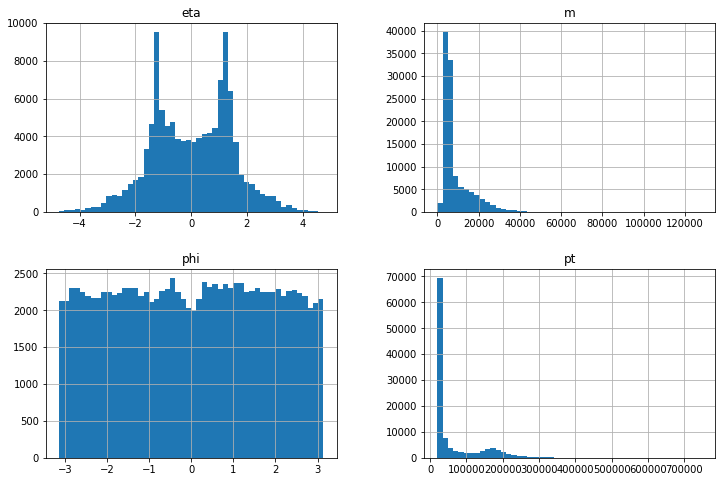

In [8]:
# checking data distribution
df.hist(figsize=(12,8), bins=50)
plt.show()

In [9]:
# checking skweness values
df.skew()

m      2.420373
pt     1.958352
phi   -0.009165
eta   -0.062186
dtype: float64

In [10]:
# custom normalization function for each feature
def normalize(df):
  df_temp = pd.DataFrame()
  df_temp['phi'] = df['phi'] / 3.0
  df_temp['eta'] = df['eta'] / 4.0
  df_temp['m'] = np.log10(df['m']+1)
  df_temp['pt'] = np.log10(df['pt'])
  return df_temp

def inverse_norm(df_norm):
  df_temp = pd.DataFrame()
  df_temp['phi'] = df_norm['phi'] * 3.0
  df_temp['eta'] = df_norm['eta'] * 4.0
  df_temp['m'] = (10**df_norm['m'])-1
  df_temp['pt'] = 10**df_norm['pt']
  return df_temp

df_norm = normalize(df)
df_norm.describe().T

,count,mean,std,min,25%,50%,75%,max
phi,111778.0,0.000564,0.601050,-1.047196,-0.519428,0.006454,0.517769,1.047182
eta,111778.0,0.010875,0.362110,-1.186349,-0.284958,0.021565,0.294728,1.186911
m,111778.0,3.832283,0.399387,-0.020157,3.668316,3.758134,4.019885,5.108053
pt,111778.0,4.627400,0.363469,4.301033,4.352467,4.433635,4.897496,5.874363


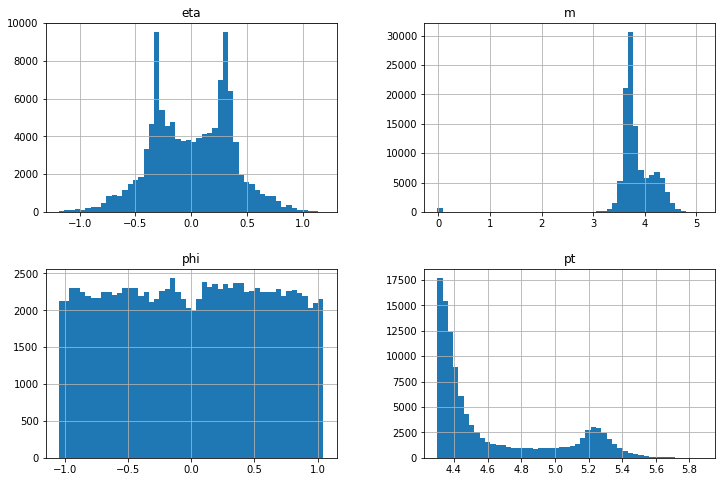

In [11]:
df_norm.hist(figsize=(12,8), bins=50)
plt.show()

In [12]:
# normalizing test set
df_test_norm = normalize(df_test)
X = df_norm.values
X_test = df_test_norm.values
X, X_test = X.astype('float32'), X_test.astype('float32')
print(X.shape, X_test.shape)

(111778, 4) (27945, 4)


In [13]:
df_test_norm.describe().T

,count,mean,std,min,25%,50%,75%,max
phi,27945.0,0.002341,0.604655,-1.047164,-0.522089,0.009406,0.523748,1.047176
eta,27945.0,0.010087,0.359800,-1.195702,-0.283597,0.017665,0.294177,1.164686
m,27945.0,3.832826,0.398385,-0.020140,3.668740,3.756826,4.021726,5.058936
pt,27945.0,4.628560,0.365982,4.301032,4.352060,4.433799,4.902812,5.895504


# Building and Training Model

In [14]:
def get_autoencoder():
  # defining the model
  input_layer = L.Input(shape=(4,))

  enc_1 = L.Dense(200)(input_layer)
  lrelu = L.LeakyReLU(0.05)(enc_1)
  bn = L.BatchNormalization()(lrelu)
  enc_2 = L.Dense(100)(bn)
  lrelu = L.LeakyReLU(0.05)(enc_2)
  bn = L.BatchNormalization()(lrelu)
  enc_3 = L.Dense(50)(bn)
  lrelu = L.LeakyReLU(0.05)(enc_3)
  bn = L.BatchNormalization()(lrelu)

  latent_vec = L.Dense(3)(bn)
  lrelu = L.LeakyReLU(0.05)(latent_vec)
  bn = L.BatchNormalization()(lrelu)

  dec_3 = L.Dense(50)(bn)
  lrelu = L.LeakyReLU(0.05)(dec_3)
  bn = L.BatchNormalization()(lrelu)
  dec_2 = L.Dense(100)(bn)
  lrelu = L.LeakyReLU(0.05)(dec_2)
  bn = L.BatchNormalization()(lrelu)
  dec_1 = L.Dense(200)(bn)
  lrelu = L.LeakyReLU(0.05)(dec_1)
  bn = L.BatchNormalization()(lrelu)

  out_layer = L.Dense(4, activation='linear')(bn)
  
  autoencoder = Model(input_layer, out_layer, name='autoencoder')
  return autoencoder

autoencoder = get_autoencoder()
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 200)               1000      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 200)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               

In [15]:
# compiling and training the model
# optim = tfa.optimizers.AdamW(1e-02,
#                             learning_rate = 5e-04)
# optim = SGD(learning_rate=1e-03, momentum=1e-04)
optim = Adam(learning_rate=1e-03)
autoencoder.compile(optimizer=optim,
                    loss='mse')

# checkpoint = ModelCheckpoint('model.hdf5',
#                              monitor='val_loss',
#                              save_best_only=True,
#                              mode='min')

autoencoder.fit(X, X,
                epochs=200,
                batch_size=1024,
                shuffle=True,
                validation_data=(X_test, X_test))

Train on 111778 samples, validate on 27945 samples
Epoch 1/200
111778/111778 [==============================] - 4s 36us/sample - loss: 8.6066 - val_loss: 7.2817
Epoch 2/200
111778/111778 [==============================] - 0s 4us/sample - loss: 6.5689 - val_loss: 4.7327
Epoch 3/200
111778/111778 [==============================] - 0s 4us/sample - loss: 3.8073 - val_loss: 1.9222
Epoch 4/200
111778/111778 [==============================] - 0s 4us/sample - loss: 1.2052 - val_loss: 0.3475
Epoch 5/200
111778/111778 [==============================] - 0s 4us/sample - loss: 0.1282 - val_loss: 0.2236
Epoch 6/200
111778/111778 [==============================] - 0s 4us/sample - loss: 0.0121 - val_loss: 0.2574
Epoch 7/200
111778/111778 [==============================] - 0s 4us/sample - loss: 0.0112 - val_loss: 0.2345
Epoch 8/200
111778/111778 [==============================] - 0s 4us/sample - loss: 0.0105 - val_loss: 0.2253
Epoch 9/200
111778/111778 [==============================] - 0s 4us/sample -

In [16]:
x_pred = autoencoder.predict(X_test)
mean_squared_error(X_test, x_pred)

0.002527966